In [1]:
import pandas as pd
import plotly.graph_objects as go

In [ ]:
csv_path = '../goodreads_library_export.csv'
df = pd.read_csv(csv_path)
date_added = pd.to_datetime(df['Date Added']).sort_values(ascending=True)

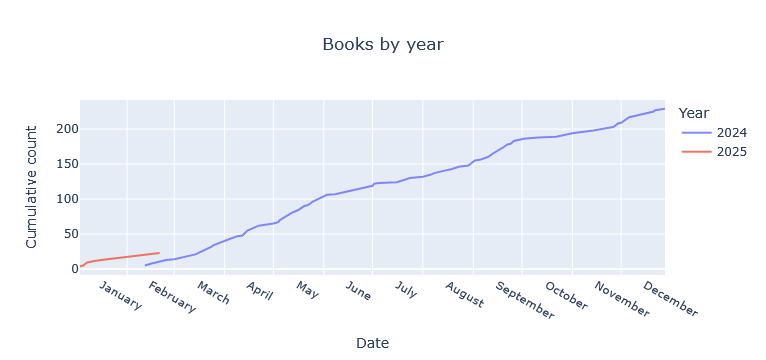

In [ ]:
fig = go.Figure()
for year, g in date_added.groupby(date_added.dt.year, sort=False):
    fig.add_trace(
        go.Scatter(
            x=g.apply(lambda x: x.replace(year=2024)).unique(), 
            y=g.value_counts(sort=False).cumsum(), 
            name=year,
            opacity=0.8,
            mode='lines',
        )
    )
fig.update_layout(
    yaxis_title='Cumulative count',
    legend_title_text='Year',
    xaxis=dict(
        tickformat='%B', dtick='M1',
        ticklabelmode="period", title='Date'
    ),
    title='Books by year', title_x=0.5
)
fig